In [1]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  1.Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from scipy.stats import randint
import seaborn as sns



# 2.Data Preprocessing and Visualization

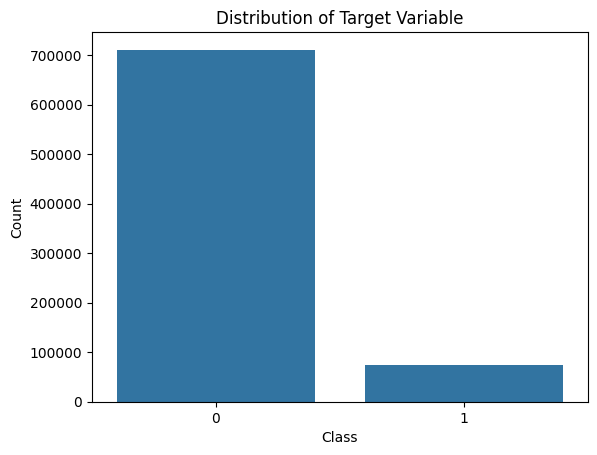

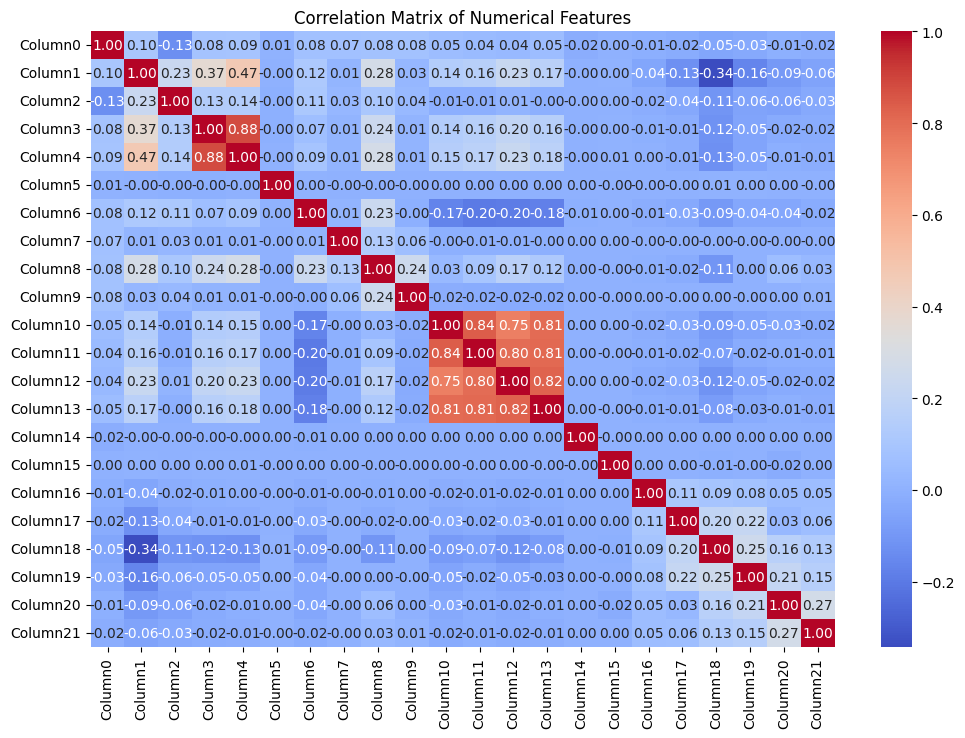

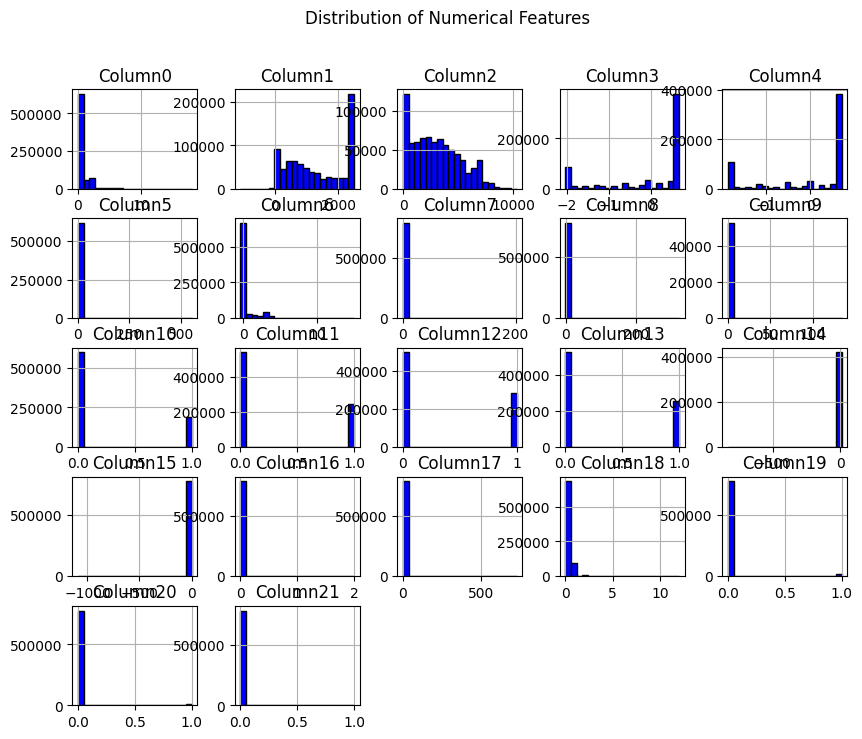

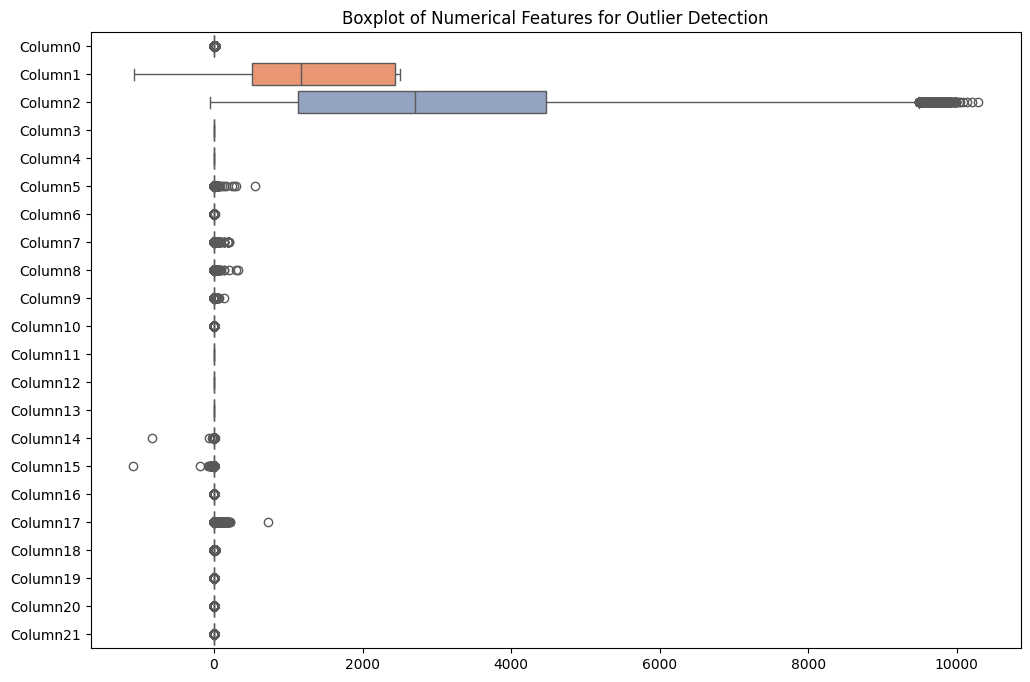

In [3]:
# Load the data
X_train = pd.read_csv('/content/drive/MyDrive/Dataset/Train_60/Train_60/X_Train_Data_Input.csv')
Y_train = pd.read_csv('/content/drive/MyDrive/Dataset/Train_60/Train_60/Y_Train_Data_Target.csv')

# Preprocessing and separating IDs
X_train_id = X_train['ID']
Y_train_id = Y_train['ID']
X_train = X_train.drop(columns=['ID'])
Y_train = Y_train.drop(columns=['ID'])

# Separate numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Data Visualization
# Visualizing the target variable
sns.countplot(x=Y_train['target'])
plt.title('Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
corr_matrix = X_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Distribution of numerical features
X_train[numeric_features].hist(figsize=(10, 8), bins=20, color='blue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Boxplot for outlier detection
plt.figure(figsize=(12, 8))
sns.boxplot(data=X_train[numeric_features], orient='h', palette='Set2')
plt.title('Boxplot of Numerical Features for Outlier Detection')
plt.show()

# 3.Feature Selection

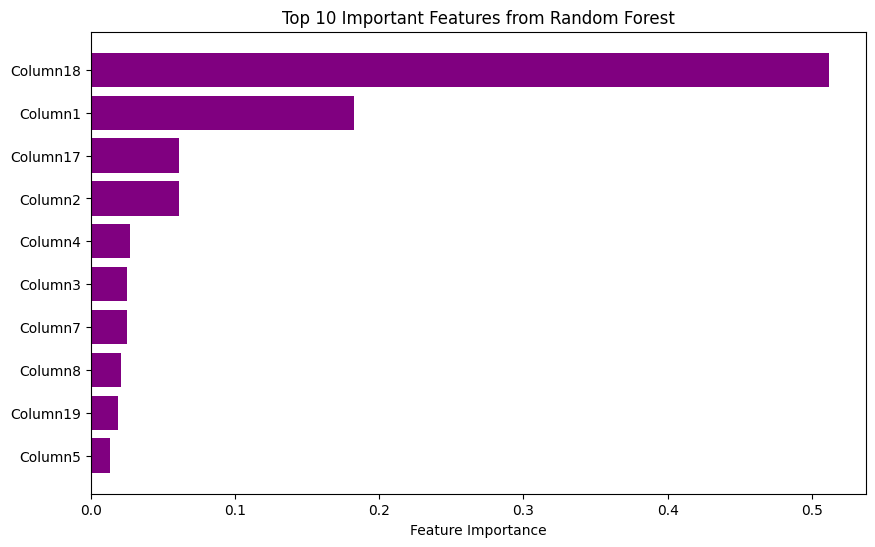

In [4]:
# Feature Selection using RandomForest to identify top features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_preprocessed, Y_train['target'])
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [numeric_features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features from Random Forest')
plt.show()

X_train_selected = X_train_preprocessed[:, indices]

In [5]:
# Split the data for validation
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(X_train_selected,Y_train['target'], test_size=0.2, random_state=42)


# 4.Model Training and Validation

In [6]:
# Define the GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=188, learning_rate=0.1, max_depth=7, random_state=42)

# Hyperparameter search space
# param_distributions = {
#     'n_estimators': randint(100, 300),
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': randint(3, 8)
# }

# # RandomizedSearchCV for hyperparameter tuning
# random_search = RandomizedSearchCV(model, param_distributions, n_iter=30, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
model.fit(X_train_split, Y_train_split)

# Save the best model
import joblib
joblib.dump(model, 'best_model_gbt.pkl')


['best_model_gbt.pkl']

Validation Accuracy: 0.9766919064874193
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    142275
           1       0.84      0.93      0.88     14752

    accuracy                           0.98    157027
   macro avg       0.92      0.95      0.93    157027
weighted avg       0.98      0.98      0.98    157027

Validation Confusion Matrix:
 [[139700   2575]
 [  1085  13667]]


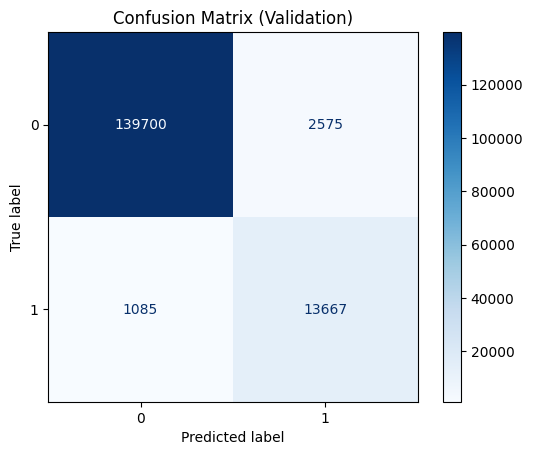

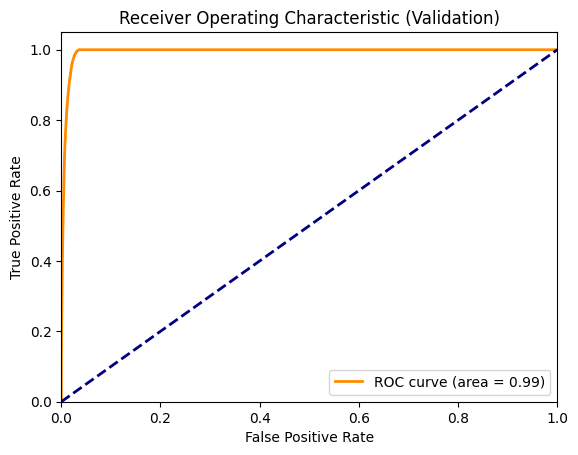

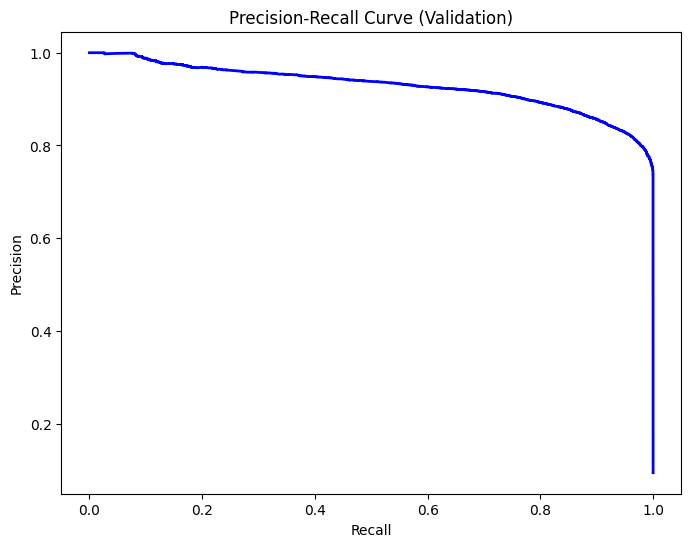

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the best model on validation data
best_model = model
Y_pred = best_model.predict(X_val_split)

#print("Best Hyperparameters:", random_search.best_params_)
print("Validation Accuracy:", accuracy_score(Y_val_split, Y_pred))
print("Validation Classification Report:\n", classification_report(Y_val_split, Y_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(Y_val_split, Y_pred))

# Confusion matrix for validation data
cm = confusion_matrix(Y_val_split, Y_pred)
disp =ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Validation)')
plt.show()

# Calculate AUC-ROC curve for validation data
y_probs = best_model.predict_proba(X_val_split)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_val_split, y_probs)
fpr, tpr, thresholds = roc_curve(Y_val_split, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Validation)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve for validation
precision, recall, _ = precision_recall_curve(Y_val_split, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation)')
plt.show()


# Test Data Preparation and Model Evaluation

Test Accuracy: 0.9766804731919057
Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.84      0.93      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.93    261712
weighted avg       0.98      0.98      0.98    261712

Test Confusion Matrix:
 [[232659   4375]
 [  1728  22950]]
Test AUC-ROC: 0.9942705221873456


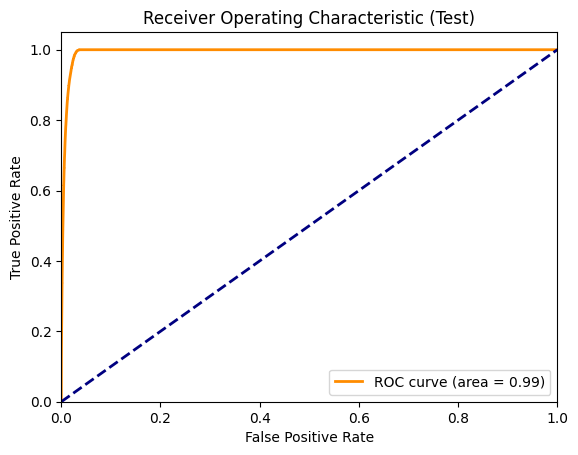

In [8]:
# Load and preprocess the test data
Dtest = pd.read_csv('/content/drive/MyDrive/Dataset/Test_20/Test_20/X_Test_Data_Input.csv')
Y_test = pd.read_csv('/content/drive/MyDrive/Dataset/Test_20/Test_20/Y_Test_Data_Target.csv')
Dtest_id = Dtest['ID']
Dtest = Dtest.drop(columns=['ID'])
Dtest_preprocessed = preprocessor.transform(Dtest)
Dtest_selected = Dtest_preprocessed[:, indices]

# Load the saved model and predict on test data
best_model = joblib.load('best_model_gbt.pkl')
Y_pred_test = best_model.predict(Dtest_selected)

# Evaluate on test data
print("Test Accuracy:", accuracy_score(Y_test['target'], Y_pred_test))
print("Test Classification Report:\n", classification_report(Y_test['target'], Y_pred_test))
print("Test Confusion Matrix:\n", confusion_matrix(Y_test['target'], Y_pred_test))

# AUC-ROC for test data
y_probs_test = best_model.predict_proba(Dtest_selected)[:, 1]
roc_auc_test = roc_auc_score(Y_test['target'], y_probs_test)
fpr_test, tpr_test, _ = roc_curve(Y_test['target'], y_probs_test)

print("Test AUC-ROC:", roc_auc_test)
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test)')
plt.legend(loc="lower right")
plt.show()

# Prepare the submission file
submission = pd.DataFrame({'ID': Dtest_id, 'target': Y_pred_test})
submission.to_csv('submission.csv', index=False)

# Evaultor Section


Please upload your model file (e.g., 'best_model_gbt.pkl').


Saving best_model_gbt.pkl to best_model_gbt (2).pkl
Please upload your X test dataset (e.g., 'X_Test_Data_Input.csv').


Saving X_Test_Data_Input.csv to X_Test_Data_Input (1).csv
Please upload your Y test dataset (e.g., 'Y_Test_Data_Target.csv').


Saving Y_Test_Data_Target.csv to Y_Test_Data_Target (1).csv
Test Accuracy: 0.9766804731919057
Test Precision: 0.8398902104300091
Test Recall: 0.9299781181619255
Test F1 Score: 0.8826413860738803
Test Log Loss: 0.05186096516421382
Test Balanced Accuracy: 0.9557604252140914
Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.84      0.93      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.93    261712
weighted avg       0.98      0.98      0.98    261712

Test Confusion Matrix:
 [[232659   4375]
 [  1728  22950]]
Test AUC-ROC: 0.9942705221873456


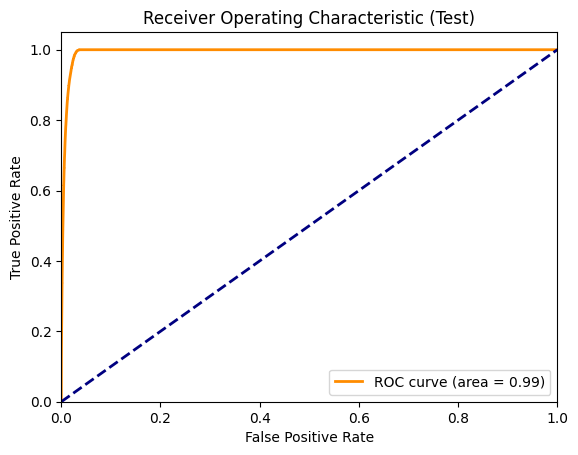

In [13]:
# Import necessary libraries
import pandas as pd
import joblib
from google.colab import files
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    log_loss,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt

# Function to upload files with prompts
def upload_files():
    print("Please upload your model file (e.g., 'best_model_gbt.pkl').")
    uploaded_model = files.upload()

    print("Please upload your X test dataset (e.g., 'X_Test_Data_Input.csv').")
    uploaded_x = files.upload()

    print("Please upload your Y test dataset (e.g., 'Y_Test_Data_Target.csv').")
    uploaded_y = files.upload()

    return uploaded_model, uploaded_x, uploaded_y

# Upload model and datasets
uploaded_model, uploaded_x, uploaded_y = upload_files()

# Load the uploaded model
model_filename = next(iter(uploaded_model.keys()))  # Get the uploaded model filename
best_model = joblib.load(model_filename)

# Load and preprocess the uploaded test data
x_filename = next(iter(uploaded_x.keys()))  # Get the uploaded X dataset filename
y_filename = next(iter(uploaded_y.keys()))  # Get the uploaded Y dataset filename

Dtest = pd.read_csv(x_filename)
Y_test = pd.read_csv(y_filename)

# Assuming the 'ID' column exists, drop it for preprocessing
Dtest_id = Dtest['ID'] if 'ID' in Dtest.columns else None
if Dtest_id is not None:
    Dtest = Dtest.drop(columns=['ID'])

# Preprocess the data (ensure 'preprocessor' and 'indices' are defined)
Dtest_preprocessed = preprocessor.transform(Dtest)  # Use your preprocessor here
Dtest_selected = Dtest_preprocessed[:, indices]  # Ensure 'indices' are defined

# Predict on test data
Y_pred_test = best_model.predict(Dtest_selected)
Y_pred_proba_test = best_model.predict_proba(Dtest_selected)[:, 1]  # Probabilities for ROC/AUC

# Evaluate on test data
accuracy = accuracy_score(Y_test['target'], Y_pred_test)
precision = precision_score(Y_test['target'], Y_pred_test)
recall = recall_score(Y_test['target'], Y_pred_test)
f1 = f1_score(Y_test['target'], Y_pred_test)
log_loss_value = log_loss(Y_test['target'], Y_pred_proba_test)
balanced_accuracy = balanced_accuracy_score(Y_test['target'], Y_pred_test)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Test Log Loss:", log_loss_value)
print("Test Balanced Accuracy:", balanced_accuracy)
print("Test Classification Report:\n", classification_report(Y_test['target'], Y_pred_test))
print("Test Confusion Matrix:\n", confusion_matrix(Y_test['target'], Y_pred_test))

# AUC-ROC for test data
roc_auc_test = roc_auc_score(Y_test['target'], Y_pred_proba_test)
fpr_test, tpr_test, _ = roc_curve(Y_test['target'], Y_pred_proba_test)

print("Test AUC-ROC:", roc_auc_test)
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test)')
plt.legend(loc="lower right")
plt.show()

# Prepare the submission file
if Dtest_id is not None:
    submission = pd.DataFrame({'ID': Dtest_id, 'target': Y_pred_test})
else:
    submission = pd.DataFrame({'target': Y_pred_test})

submission.to_csv('submission.csv', index=False)
